# Development of a Multilayer Perceptron for Identifying PPARg Ligands (Agonists and Antagonists)

This work is focused on developing a deep autoencoder model that can identify molecules that are likely to bind the PPARg receptor.

**Objective:** To be able to use structure information only to identify if a chemical is likely to bind to the PPARg.

**Approach:** 

1) Putative agonists will be obtained from the Tox21 Assay for PPARg agonists (https://pubchem.ncbi.nlm.nih.gov/bioassay/743140). 

2) Putative antagonists will be obtained from the Tox21 Assay for PPARg antagonists (https://pubchem.ncbi.nlm.nih.gov/bioassay/743199). 

3) Negatives will also be obtained from both summary studies.

4) LOOXV will be used to estimate accuracy.

Files from PubChem were processed using the pubchem_to_chem_info.py script. This was done outside of the notebook. Data preparation was also performed outside of the notebook. 

In [11]:
%matplotlib inline

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

Now that we have all of the libaries loaded, we will set our seed and load up the data.

In [40]:
#setting the seed for reproducibility
#seed = 10110
seed = 1206
numpy.random.seed(seed)

#load the dataset
dataframe = pandas.read_csv("F:/UOSEST/Data/Lyle-pparg-ligand/input/pubchem_data/processed/pparg_ligand_data.txt", sep="\t")

not_ligand    762
ligand         34
Name: Type, dtype: int64

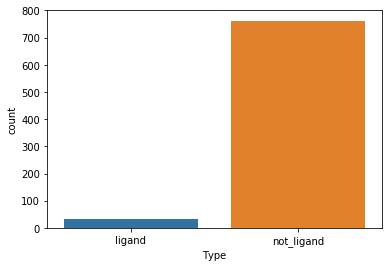

In [13]:
import seaborn as sns
d = dataframe
sns.countplot(d['Type'])
d['Type'].value_counts()

In [30]:
d['Type'].value_counts()

not_ligand    762
ligand         34
Name: Type, dtype: int64

The next step is to build the fingerprints. For this I am using the RDKit library. I prefer to use Morgan fingerprints for QSAR. Morgan fingerprints are 2-dimensional fingerprints. A circle of a defined radius is used define the neighborhood, and the neighborhood becomes the fingerprint. The RDKit has a far better explanation (http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints).

In [14]:
mols = []
fps = []

#get molecules and then get fingerprints from those
for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    mols.append(mol)
    fps.append(fp)

#Convert the RDKit vectors into numpy arrays
#Based on: http://www.rdkit.org/docs/Cookbook.html#using-scikit-learn-with-rdkit
np_fps = []
for fp in fps:
    arr = numpy.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

Now that we have fingerprints, we are going to encode our labels. Note that in the input file, our lables are "ligand" and "not_ligand". Keras would prefer we give it numeric labels, so I used the LabelEncoder function from sci-kit learn to encode the strings as integers.

In [15]:
#Need to encode my classes
#Ligand = 0, not_ligand = 1
encoder = LabelEncoder()
encoder.fit(dataframe['Type'])
enc_y = encoder.transform(dataframe['Type'])

In [ ]:
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
def binary_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    epsilon = K.epsilon()
    # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
           -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

return binary_focal_loss_fixed

In [16]:
#Create the machine learning model
from keras import optimizers
def create_deep_learning_model():
    model = Sequential()
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
y_pred= [0,1,0,1,0,1,0,1,0,1]
y_true = [0,0,0,0,0,0,0,1,1,1]
confusion_matrix(y_true, y_pred)

array([[4, 3],
       [1, 2]], dtype=int64)

Now it's time to train the machine learning model. This model isn't very actually deep -- it doesn't need to be. It's a rather simple multilayer perceptron. The first layer is the input layer (and it is not specified). The second layer is a hidden, dense neural network where each neuron is connected to each feature. This gets narrowed down quickly to the third layer, and finally a single neuron output layer.

In [ ]:
#Create the machine learning model
from keras import optimizers
def create_deep_learning_model():
    model = Sequential()
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=[focal_loss], optimizer=sgd, metrics=['accuracy'])
    return model

In [ ]:
enc_y = numpy.array(list(enc_y))
nonactive = enc_y[enc_y==1][:100]

In [ ]:
np_fps_array_na=np_fps_array[enc_y==1][:100]

In [ ]:
nonactive.shape

In [ ]:
np_fps_array = numpy.concatenate( [np_fps_array[enc_y==0], np_fps_array_na] )

In [ ]:
enc_y = numpy.concatenate( [enc_y[enc_y==0], nonactive])

In [65]:
from sklearn.utils import shuffle
seed = 5465466
numpy.random.seed(seed)
tmp = [[x,y] for x, y in zip(np_fps_array, enc_y)]
tmp = shuffle(tmp)
X= [n[0] for n in tmp]
Y = [n[1] for n in tmp]

In [66]:
n = len(X)
p = 0.8
X_test = X[int(n*p):]
Y_test = Y[int(n*p):]

X_train = X[:int(n*p)]
Y_train = Y[:int(n*p)]

1    610
0     26
dtype: int64

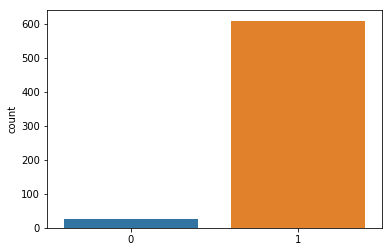

In [67]:
import seaborn as sns
d = dataframe
sns.countplot(Y_train)
pandas.Series(Y_train).value_counts()

1    152
0      8
dtype: int64

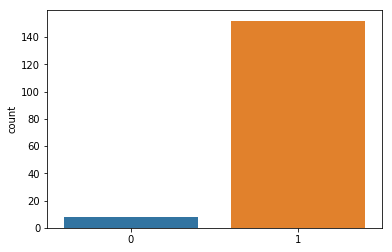

In [68]:
import seaborn as sns
d = dataframe
sns.countplot(Y_test)
pandas.Series(Y_test).value_counts()

In [ ]:
n = 0
for (index, i) in enumerate(Y_train) :
    if(i==0) :
        print(index)
        break
    

In [ ]:
sm = SMOTE(random_state=12, ratio = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [ ]:
numpy.savetxt("F:/UOSEST/Data/Lyle-pparg-ligand/active_sample_after_smote.csv", x_train_res[27], delimiter=",")

In [ ]:
class_weight={0:0.5, 1:1e-3}

In [ ]:
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=100, batch_size=10, class_weight =class_weight)

In [ ]:
estimator.fit(x_train_res, y_train_res,class_weight=class_weight)

In [76]:
len(X_train)

636

In [96]:
Y_train= numpy.array(Y_train)
Y_pred

# no sampling

In [97]:
X_train = numpy.array(X_train)
estimator = create_deep_learning_model()
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=10, batch_size=10)
estimator.fit(X_train, Y_train, epochs=5, batch_size = 5)

Epoch 1/5
636/636 [==============================] - 1s 2ms/step - loss: 0.2357 - acc: 0.9528
Epoch 2/5
636/636 [==============================] - 1s 1ms/step - loss: 0.0883 - acc: 0.9686
Epoch 3/5
636/636 [==============================] - 1s 1ms/step - loss: 0.0402 - acc: 0.9906
Epoch 4/5
636/636 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 0.9969
Epoch 5/5
636/636 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 1.0000


In [112]:
X_test = numpy.array(X_test)
Y_test = numpy.array(Y_test)
Y_pred = estimator.predict(X_test)
y_pred = [] 
for i in Y_pred : 
    if(i> 0.5) :
        y_pred.append(1)
    else : 
        y_pred.append(0)

In [113]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [115]:

conf_mat = confusion_matrix(Y_test, y_pred)

In [116]:
conf_mat

array([[  0,   8],
       [  0, 152]], dtype=int64)

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def graph(target) :
    class_RF = y_te[target][rows_te].ravel()
    proba_RF = p_te[:,1]

    false_positive_rate_RF, true_positive_rate_RF, thresholds_RF = roc_curve(class_RF, proba_RF)
    roc_auc_RF = auc(false_positive_rate_RF,true_positive_rate_RF)
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate(1 - Specificity)')
    plt.ylabel('True Positive Rate(Sensitivity)')


    plt.plot(false_positive_rate_RF, true_positive_rate_RF, 'b', label='Model RF (AUC = %0.2f)'% roc_auc_RF)
    plt.plot([0,1],[1,1],'y--')
    plt.plot([0,1],[0,1],'r--')

    plt.legend(loc='lower right')
    plt.show()

    fig.savefig(target+ '_RF.png')

In [ ]:
list(Y_test).count(0)

In [ ]:
y_pred = estimator.predict(numpy.asarray(X_test[:50]))

In [ ]:
confusion_matrix(Y_test[:50],y_pred[:50])

In [ ]:

# evaluate model with standardized dataset
#estimator = KerasClassifier(build_fn=create_deep_learning_model, nb_epoch=100, batch_size=5, verbose=0)
#estimator = KerasClassifier(build_fn=create_deep_learning_model, nb_epoch=10, batch_size=5) #changed to nb epoches
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=10, batch_size=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, np_fps_array, enc_y, cv=kfold)
# results = cross_val_score(estimator, x_train_res, y_train_res, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

y_pred = cross_val_predict(estimator, x_train_res, y_train_res, cv=kfold)
conf_mat = confusion_matrix(y_train_res, y_pred)
conf_mat

In [ ]:
x_train_res

In [ ]:
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=2,batch_size=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, np_fps_array, enc_y, cv=kfold)
results = cross_val_score(estimator, x_train_res, y_train_res, cv=kfold)

In [ ]:
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=1,batch_size=5)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, np_fps_array, enc_y, cv=kfold)
results = cross_val_score(estimator, x_train_res, y_train_res, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

We can see that we have reasonable performance.

What we notice right away is that we have some misclassifications -- as expected. We have 6 ligand cases misclassified as not-ligand, and we have 8 not-ligand cases misclassified as ligand. Overall the model is performing quite well.

From a practical standpoint, we are interested in knowing what is the probability that a chemical is actually a PPARg ligand if the model says it is. We will use Bayes rule to calculate this.

Note that some of the exact percentages may be off due to weirdness with respect to the random seed not leading to 100% reproducible results. I'm not sure why this is.

Based on the Tox21 data we have, we have a prior probability that a chemical is a PPARg ligand of 4% (33/796), and a prior probability of not being a PPARg ligand of 96% (100%-4%).

Our evidence from the model is encapsulated in the confusion matrix and the figure above. For ease of calculation, we are going to use the confusion matrix (if we used information from the plot the likelihood values would not change much). The probability that the model predicts a chemical to be a ligand given the fact that it actually is a ligand is the true positive rate, which is about 99% (756/(756+6)). The probability that the model predicts a chemical to  be a ligand when it is not a ligand is the false positive rate, which is about 1.0% (8/(8+754)). 

The posterior probability that a chemical is a ligand given that the model predicts it is a ligand is: 

P(ligand | predicted ligand) = (0.99 x 0.04)/((0.99 x 0.04)+(0.01 x 0.96) = 0.80

Likewise, the posterior probability that a chemical is not a ligand given that the model predicts it is a ligand is:

P(not ligand | predicted ligand) = (0.017 x 0.96)/((0.017 x 0.96)+(0.99 x 0.04) = 0.20

This resuls in a posterior odds of 0.80/0.20 = 4:1

Interestingly, we started with prior odds of a chemical being a ligand of 0.04 / 0.96 = 1:24. What this means is that out of the box, we would expect that only 4% of chemicals chosen at random would be a PPARg ligand. Our likelihood ratio of a predicted ligand being a ligand to a predicted ligand not being a ligand is 0.99 / 0.01 = 99:1. The likelihood ratio is the evidence that we have from the model -- based on the validation data the chemical has a true positive rate of 99% and a false positive rate of 0.5%. Put these lines of evidence together, and we have a posterior odds of 4:1. What this means is that if the model states that the chemical is a PPARg ligand, then we have 8.90:1 odds that it is a PPARg ligand.



Now I'm going to do some chemical structure comparisons graphically to see if I can identify some structures that ligands might share. This isn't an exhaustive search, and one isn't possible. However, this may help to illuminate some structures that are shared by known ligands. In this case, I'm going to be focusing on the known ligands pirinixic acid, liothyronine, oxaprozin, lansoprazole, romazarit, and linoleic acid.

In [ ]:
pirinixic_acid = Chem.MolFromSmiles('CC1=C(C(=CC=C1)NC2=CC(=NC(=N2)SCC(=O)O)Cl)C')
liothyronine = Chem.MolFromSmiles('C1=CC(=C(C=C1OC2=C(C=C(C=C2I)CC(C(=O)O)N)I)I)O')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(pirinixic_acid, liothyronine, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
oxaprozin = Chem.MolFromSmiles('C1=CC=C(C=C1)C2=C(OC(=N2)CCC(=O)O)C3=CC=CC=C3')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(pirinixic_acid, oxaprozin, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
lansoprazole = Chem.MolFromSmiles('CC1=C(C=CN=C1CS(=O)C2=NC3=CC=CC=C3N2)OCC(F)(F)F')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(pirinixic_acid, lansoprazole, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
romazarit = Chem.MolFromSmiles('CC1=C(OC(=N1)C2=CC=C(C=C2)Cl)COC(C)(C)C(=O)O')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(pirinixic_acid, romazarit, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
linoleic_acid = Chem.MolFromSmiles('CCCCCC=CCC=CCCCCCCCC(=O)O')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(pirinixic_acid, linoleic_acid,
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(linoleic_acid, pirinixic_acid, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(liothyronine, linoleic_acid,  
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(linoleic_acid, liothyronine,   
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(oxaprozin, linoleic_acid, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(linoleic_acid, oxaprozin,  
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(lansoprazole, linoleic_acid, 
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(linoleic_acid, lansoprazole,  
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(romazarit, linoleic_acid,  
                                                               SimilarityMaps.GetMorganFingerprint)

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(linoleic_acid, romazarit, 
                                                               SimilarityMaps.GetMorganFingerprint)

Of all the ligands, linoleic acid is the one that is most at risk of looking like a non-ligand; however, it still has a very strong probability at 0.057 (recall that scores closer to 0 are more likely ligands, while scores closer to 1 are more likely non-ligands. Let's examine how the linoleic acid structure compares to many of the others.

Just among this small random sampling of chemicals, a few characteristics are beginning to emerge. Keep in mind, these compounds represent agonists and antagonists. The reference compound, pirinixic acid, oxaprozin, and romazarit are agonists. Liothyronine and lansoprazole are antagonists.

What one sees is that aromatic groups, carboxylic acids, and imines tend to be shared amongst the group of ligands. In addition, oxazole rings, ethers, and amines tend to not be shared amongst the PPARg ligands, based on comparison to the prototypic pirinixic acid structure. 

## Writing the Prediction Results to File

In [ ]:
confusion_df.to_csv("./confusion_matrix.txt", sep='\t', index=False, header=False)

Next, the model is saved.

In [ ]:
# model = create_deep_learning_model()
# model.fit(x_train_res, y_train_res, epochs=5, batch_size=5, ) #This code has no effect on model accuracy.
model.save('pparg_ligand_model(estimator).h5')